# So a Robot Walks into a Bar...

## Beers Have Style
Schwartzbier, real ale, wheat beer, Kölsch... many things can define a beer's style. In the professional brewing world, styles are typically differentiated by appearance, flavor, ingredients, production method, history, or origin. Unfortunately, not everyone agrees on how to categorize beer styles, and brewers often flip flop their beers between categories for competitions and distributors in different parts of the world. For instance, take a look at differences between CAMRA's Champion Beer of Britain, the Beer Judge Certification Program (BJCP), the Brewers Association's World Beer Cup). Furthermore, new styles are invented all the time as breweries try to differentiate their creations, and angsty beer geeks are given reason to wage sudsy wars in online forums. But even the most time-honored styles were once new (even lagers were invented less than 200 years ago). Our preferences both shape and are shaped by this long, organic process.

Meanwhile, back at the brewery, a brewer is mindfully formulating and testing beer according to precise scientific standards. This precision ensures that a Sierra Nevada Pale Ale tastes just as good no matter when or where you drink it. The subjective qualities of beer styles are transformed. Color is identified according to the Standard Reference Method (SRM), bitterness is quantified on the scale of International Bitterness Units (IBUs), and a beer's capacity for danger and fun is measured by its alcohol content (percentage of alcohol by volume, or ABV). Many other metrics exist, but these are the big three. Give a Certified Cicerone (beer sommelier) these three pieces of information, and he or she could probably tell you its style without even tasting it.

## Beer by Numbers
Robots are taking over the world, if you haven't noticed. Once they're fed the right data, they can make independent decisions. That got me thinking... if I fed a robot beer data and asked it to come up with its own style categories, what would they look like? Can styles be determined quantitatively, based on SRM, IBU, and ABV alone?

## Categorizing Beer Styles with Machine Learning
Data science provides the tools to gather this beer data and feed it to a robot (i.e., a computer). Asking the computer to find structure within a collection of unlabeled data perfectly describes an unsupervised machine learning problem. We'll provide a long list of beers' SRM, IBU, and ABV metrics, and see if the computer can differentiate different categories, or "clusters", of beer. [Python 3.5](https://python.org) is my preferred language for data analysis because of its wide variety of powerful, open-source packages. 

PS -- To learn more about clustering methods, check out this tutorial from the [Polytechnic Institute of Milan](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/).

## The Analysis
I assume you're not here to get slapped with lines of code, so I streamlined this analysis by making a Python package called <tt>bdb_utils</tt>. Don't worry, the fun stuff is still on this page. But feel free to look into <tt>bdb_utils</tt> on [my Github page](https://github.com/mrstepanovic/suds/blob/master/bdb_utils.py).

### Collecting Data
Beer data was collected from [BreweryDB](http://www.brewerydb.com/)'s web API, a moderated, crowd-sourced database of beer releases in development since 2009. I've been playing with it for just about three weeks and love it for its squeaky-clean data. 

In [2]:
import pandas as pd
import numpy as np
import bdb_utils
import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/mrstep/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [278]:
# Add your BreweryDB API key here.
#c7638c9e8a98b169c092481ba409bd9f
API_KEY = "c7638c9e8a98b169c092481ba409bd9f"
URL = "http://api.brewerydb.com/v2/beers/"

# Set parameters for BreweryDB's API.
params = dict(key=API_KEY, withBreweries='Y')

# Attempt to download 10,000 randomly-chosen beers from the database.
beer_data = bdb_utils.download_data(URL, params, 10000, False)

# Also, save the data to a .csv for safe keeping offline.
beer_data.to_csv("beer_data_10k.csv")

### Exploring the Data

I'm a big fan of trivia and like to pretend I'm gathering trivia facts during exploratory data analysis (EDA). I'm also checking various statistical assumptions we might subject the data to later. 

#### Trivia Question 1
How many unique beers and styles were collected?

In [6]:
number_of_beers = beer_data['Beer Name'].nunique()
number_of_styles = beer_data['Style'].nunique()

print("{} beers of {} styles were collected.".format(number_of_beers, number_of_styles))

5186 beers of 146 styles were collected.


Over 5,000! Prost.

#### Trivia Question 2
What are the top 10 most popular styles?

[<matplotlib.text.Text at 0x10cc409b0>, <matplotlib.text.Text at 0x113da53c8>]

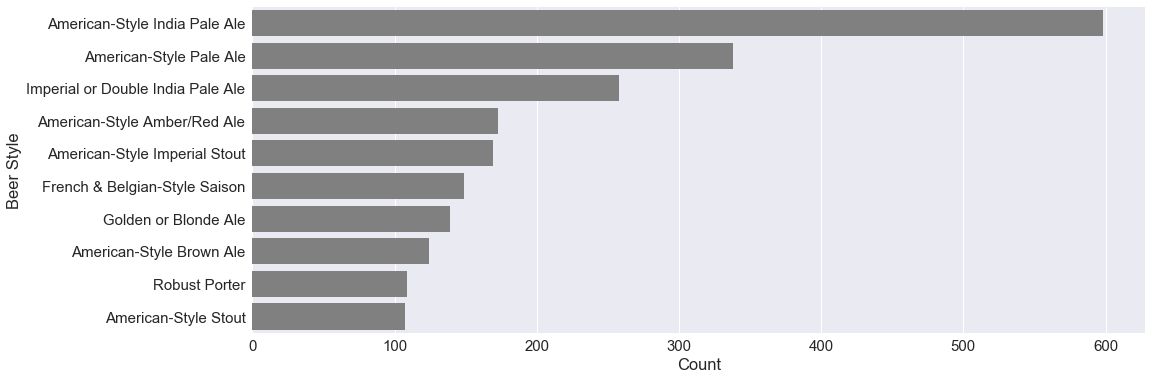

In [29]:
def top_n_styles(n):
    return pd.value_counts(beer_data['Style']).iloc[:n].index
top_ten = top_n_styles(10)

sns.set(font_scale = 1.5)
fig1 = plt.figure(figsize=(16, 6))

ax = sns.countplot(y="Style", data=beer_data, color='gray', order=top_ten)
ax.set(xlabel='Count', ylabel='Beer Style')

American IPAs dominate the dataset by a landslide, followed by American Pale Ales and Imperial/Double IPAs. I'm assuming that most contributors to BreweryDB are American, and beer-conscious Americans have a hop obsession. Lagers and malt-heavy styles have traditionally dominated most of Europe. The malt vs. hops war is currently in [full swing](http://www.sfexaminer.com/stop-pretending-like-ipas/).

#### Trivia Question 3
What is the distribution of each beer metric?

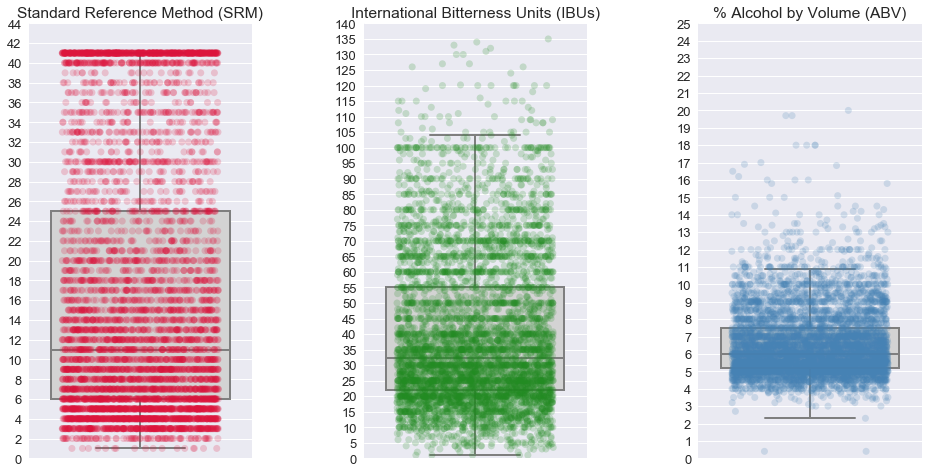

In [45]:
sns.set_style("whitegrid")
sns.set(font_scale = 1.3)

fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,8))
fig2.subplots_adjust(wspace=0.5)

for ax in [ax1, ax2, ax3]:
    ax.yaxis.label.set_visible(False)

def make_boxplot(column, axis, color='lightgray', df=beer_data):
    sns.boxplot(data=df, 
                y=column, 
                ax=axis, 
                color=color, 
                linewidth=2, 
                width=0.8, 
                showfliers=False)

def make_stripplot(column, axis, color='purple', df=beer_data):
    sns.stripplot(data=df, 
                  y=column,
                  ax=axis, 
                  jitter=.35, 
                  color=color, 
                  size=7,  
                  alpha=.2)

ax1.set(ylim=(0, 44), yticks=(np.arange(0, 45, 2)), title="Standard Reference Method (SRM)")
make_boxplot("SRM", ax1)
make_stripplot("SRM", ax1, color='crimson')

ax2.set(ylim=(0, 140), yticks=(np.arange(0, 141, 5)), title="International Bitterness Units (IBUs)")
make_boxplot("IBU", ax2)
make_stripplot("IBU", ax2, color='forestgreen')

ax3.set(ylim=(0, 25), yticks=(np.arange(0, 26, 1)), title="% Alcohol by Volume (ABV)")
make_boxplot("ABV", ax3)
make_stripplot("ABV", ax3, color='steelblue')

I like using box plots to quickly visualize centrality measures in a dataset. To squeeze even more information about the distribution of each variable, I've layered all 5,000+ data points atop the box plots as jittered strip plots. We see that each variable is distributed asymmetrically, with outliers lending to a long-tailed positive skew. Unlike IBU and ABV, SRM is an interval variable with discrete values, which we see as distinct "rungs" in its plot. We also see a high frequency of datapoints at the top of the SRM scale, which likely represents noise in the dataset. I assume many brewers want to push themselves to concoct suds with the darkest malt possible. It's kind of like a badge of honor, and it's hella rad in the cold months. Alternatively, people might not be so adept at distinguishing between SRM values towards the top of the scale.

## Clustering

Now that we know a little bit about our beer data, let's feed it to a robot. I'll try this with two different clustering algorithms, [each of which has plusses and minueses](http://nbviewer.jupyter.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb). The first one I'll try is the most popular and most intuitive: the k-means algorithm implemented in `sklearn`. The K-means algorithm tries sort samples into K different groups of equal variance.

I'll need to preprocess the data because each variable uses its own proprietary unit of measure. It's not intuitive to think of IBU in terms of SRM, for example.

In [47]:
from sklearn.preprocessing import StandardScaler

# Preprocess data by subtracting mean and scaling to unit variance.
beer_measures = beer_data.as_matrix(columns=['SRM', 'IBU', 'ABV'])
X = StandardScaler().fit_transform(beer_measures)

In order to perform a k-means clustering analysis, we have to give the computer a hint about how many clusters it needs to find. There's no definitive way to know this, so we must rely on what we think is reasonable based on our assumptions about beer and the data we have. Based on SRM, IBU, and ABV alone, I think the computer will find a maximum of 20 discernable clusters. I'll iteratively try them all with `sklearn.cluster.KMeans` and use the elbow plot method, which illustrate what percentage of the data's variance is explained by choosing K number of clusters.

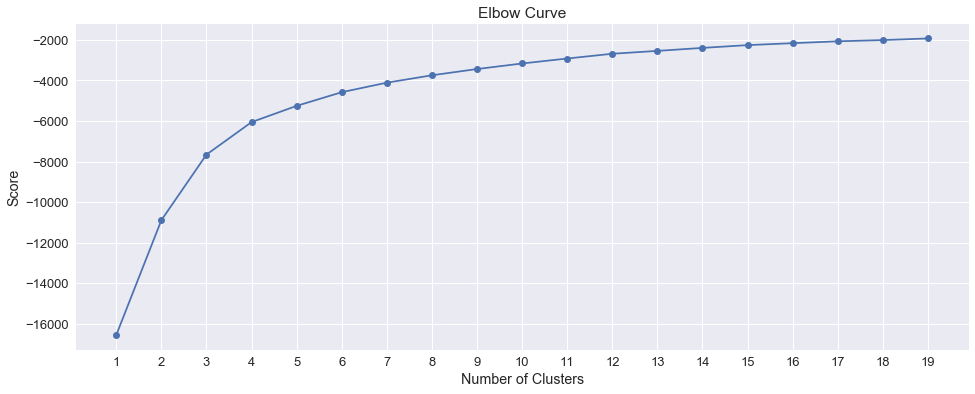

In [54]:
from sklearn.cluster import KMeans
import numpy as np

# Calculate k-means fit for all Ks from 1 to 20.
k = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in k]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

# Plot the k-means score (percent variance explained) for each K.
fig = plt.figure(figsize=(16, 6))
plt.xticks(np.arange(21))
plt.plot(k, score, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

The elbow method tells us to look to where the percent of variance explained (in this case, the score) reduces sharply with increasing K. It looks like that value is somewhere between 4 and 12 clusters. 

I'll look at a second algorithm, [DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan), which defines clusters as regions of high density surrounded by regions of low density. It requires definitions about how to define the maximum distance between points belonging to a single cluster ("epsilon") and the minimum samples it should consider to belong to the same neighborhood of points.

In [78]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=20).fit(X)
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 7


With these parameters, DBSCAN identified 7 clusters. That seems like a reasonable starting point for this our clustering analysis.

### Results

If you ask a robot to categorize all of this beer into seven styles based on SRM, IBU, and ABV alone, this is what it would look like.

In [79]:
import plotly.plotly as py
import plotly.graph_objs as go

k = 7
colors = ["green", "red", "blue", "gold", "aqua", "orange", 
          "violet", "salmon", "wheat", "lime", "chartreuse", "crimson"]

def make_cluster_points(name, cluster_df, color):
    return dict(mode="markers", 
                name=name, 
                type='scatter3d',
                text=cluster_df.as_matrix()[:,2],
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                marker=dict(size=4, color=color))

def make_cluster_mesh(name, cluster_df, color):
    return dict(alphahull=0,
                name=name,
                opacity=0.1,
                type="mesh3d",    
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                color=color,
                showscale=False)

beer_measures = beer_data.as_matrix(columns=['SRM', 'IBU', 'ABV'])
X = StandardScaler().fit_transform(beer_measures)

k_est = KMeans(n_clusters=k)
k_est.fit(X)
beer_data['cluster'] = k_est.labels_

clusters = {}
points = {}
meshes = {}

for x in range(k):
    clusters[x] = beer_data.loc[beer_data['cluster'] == x]
    points[x] = make_cluster_points("Cluster {}".format(x+1), clusters[x], colors[x])
    meshes[x] = make_cluster_mesh("Cluster {}".format(x+1), clusters[x], colors[x])

camera = dict(up=dict(x=0, y=0, z=1), 
              center=dict(x=0, y=0, z=0), 
              eye=dict(x=-1.6, y=-1.6, z=1))

layout = go.Layout(scene = dict(xaxis = dict(range = [0,45], title='SRM'),
                                yaxis = dict(range = [0,150], title='IBU'),
                                zaxis = dict(range = [0,30], title='ABV'),
                                camera=camera),
                                margin=dict(r=20, l=20),
                   width=800, height=800, showlegend=False)

plotted = [points[x] for x in points]
plotted.extend([meshes[x] for x in meshes])

fig2 = go.Figure(data=plotted, layout=layout)

py.iplot(fig2)

ModuleNotFoundError: No module named 'plotly'

## Discussion
* Robots don't see x, they see y
* These results are fascinating, but they reveal that there's a profound human element to beer's role in the world.
* Code available on Github

## Post to Social Media